In [1]:
%pip install scikit-learn numpy pandas matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd

X, Y = load_breast_cancer(return_X_y=True)
Y[Y == 0] = -1

print(f"X shape: {X.shape}")
print(f"y shape: {Y.shape}")
print(f"Classes: {np.unique(Y)}")

X shape: (569, 30)
y shape: (569,)
Classes: [-1  1]


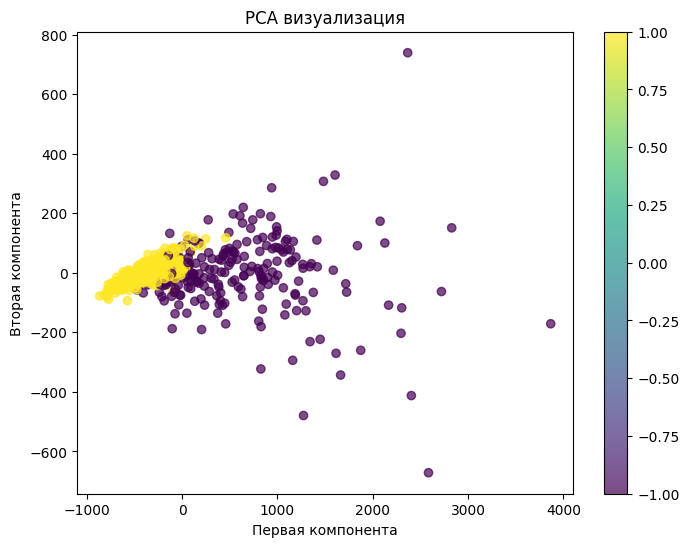

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('PCA визуализация')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.show()


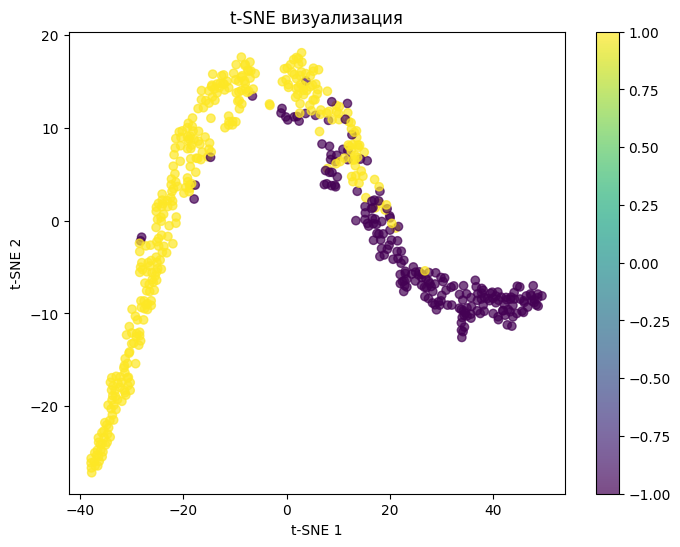

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE визуализация')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.01,
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")


Confusion Matrix:
[[ 56   7]
 [  2 106]]

Accuracy: 0.947
Precision: 0.948
Recall: 0.947
F1-score: 0.947


100%|██████████| 100/100 [00:00<00:00, 259.35it/s]


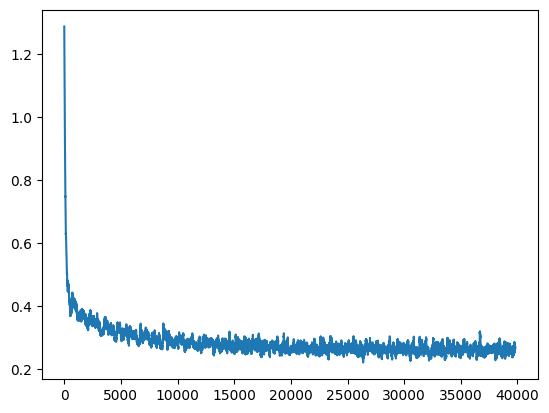

In [15]:
import matplotlib.pyplot as plt
from source.sgd_classifier import SimpleSGDClassifier
from source.optimizers import SGDOptimizer

class LossTracker:
    def __init__(self):
        self.losses = []

    def callback(self, Q):
        self.losses.append(Q)

sgd = SimpleSGDClassifier(optimizer=SGDOptimizer(), weight_init="corr")
tracker = LossTracker()

sgd.fit(X_train, y_train, tracker.callback)
plt.plot(tracker.losses)
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

preds = sgd.predict(X_test)

cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.3f}")

f1 = f1_score(y_test, preds, average='weighted')
print(f"F1-score: {f1:.3f}")

precision = precision_score(y_test, preds, average='weighted')
recall = recall_score(y_test, preds, average='weighted')
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Confusion Matrix:
[[ 56   7]
 [  2 106]]
Accuracy: 0.947
F1-score: 0.947
Precision: 0.948
Recall: 0.947


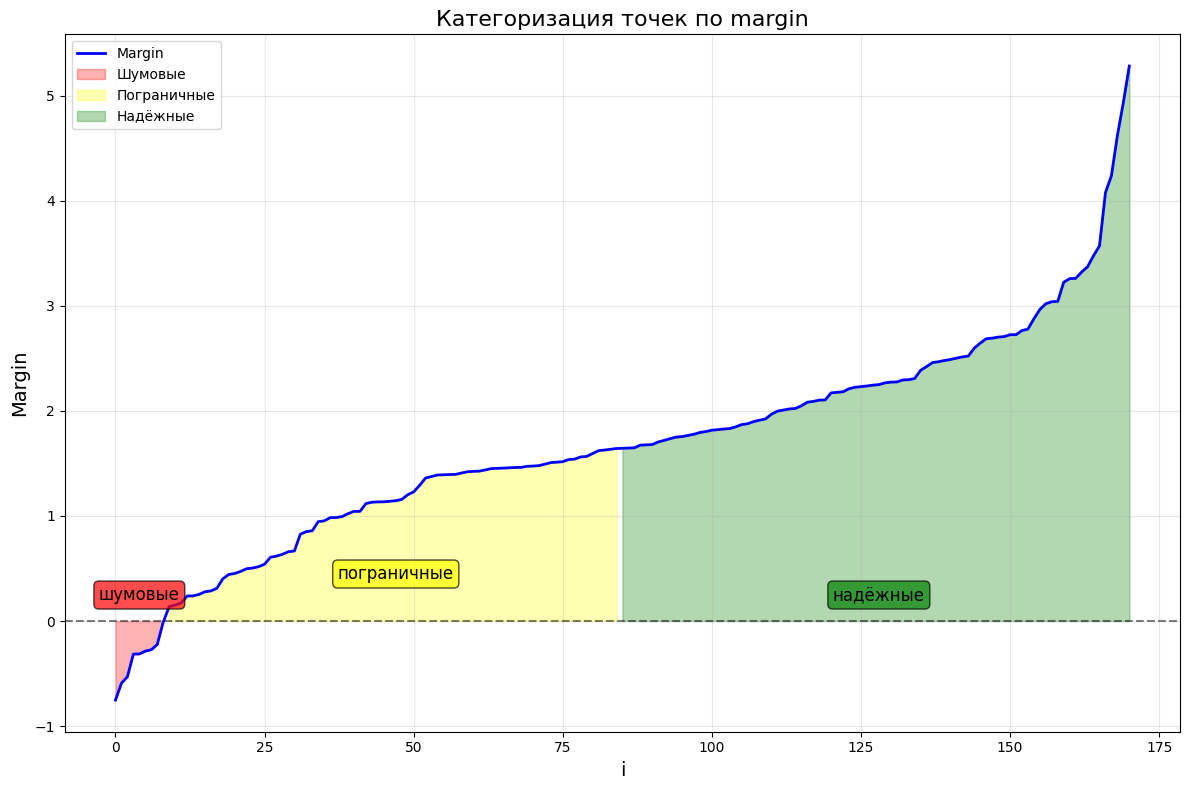

In [18]:
margins = y_test * (X_test @ sgd.w + sgd.w0)

sorted_indices = np.argsort(margins)
sorted_margins = margins[sorted_indices]

plt.figure(figsize=(12, 8))

plt.plot(range(len(sorted_margins)), sorted_margins, 'b-', linewidth=2, label='Margin')

n_points = len(sorted_margins)
noisy_end = np.where(sorted_margins >= 0)[0][0] if np.any(sorted_margins >= 0) else n_points
borderline_end = int(0.5 * n_points) 

x_range = np.arange(n_points)

if noisy_end > 0:
    plt.fill_between(x_range[:noisy_end], sorted_margins[:noisy_end], 0, 
                     color='red', alpha=0.3, label='Шумовые')
    plt.text(noisy_end//2, 0.2, 'шумовые', fontsize=12, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7))

if noisy_end < borderline_end:
    plt.fill_between(x_range[noisy_end:borderline_end], 
                     sorted_margins[noisy_end:borderline_end], 0, 
                     color='yellow', alpha=0.3, label='Пограничные')
    plt.text((noisy_end + borderline_end)//2, 0.4, 'пограничные', fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

if borderline_end < n_points:
    plt.fill_between(x_range[borderline_end:], 
                     sorted_margins[borderline_end:], 0, 
                     color='green', alpha=0.3, label='Надёжные')
    plt.text((borderline_end + n_points)//2, 0.2, 'надёжные', fontsize=12, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.7))

plt.xlabel('i', fontsize=14)
plt.ylabel('Margin', fontsize=14)
plt.title('Категоризация точек по margin', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()